# White Noise: Data Analysis

## 1. Explaining the Problem

After retrieving, processing, enriching, and cleaning the data, wish to formally assess my research question and hypotheses. In my `white_noise.csv` file I have 21820 rows - i.e., bills or documents - and eleven columns - i.e., the three identifiers, the summary texts, the two labels, and the five types of information I retrieved as metadata. Now, I must carry out an explorative and statistical analysis. On one hand, I visualise the number of bills classified as Economic or Non-Economic, and Socio-Cultural or Non-Socio-Cultural, that were introduced in the US Congress chambers over time by the two parties - i.e., the Republicans, and Democrats - comparing Obama's presidency's first two years (2008-10) against Trump's mandate's two initial years (2016-18).

On the other, I estimate two fixed-effects Linear Probability Models predicting a bill's likelihood of being Economic, or Socio-Cultural, respectively. The independent variable is time - i.e., `congress`, a dummy set to 1 if the bill was submitted during the 115th Congress (2016-18). I control its effect for state-specific characteristics, accounting for the diversity between legislators that are elected by different constituencies. I conclude by explaining why I chose to employ the OLS estimator instead of logistic regressions, and why mixed-effects models could be promising methodological tools for future research.

In [1]:
# Packages for data handling and wrangling
import numpy as np
import pandas as pd

# Packages for explorative analysis and graphic visuals
import seaborn as sns
import matplotlib.pyplot as plt

# Package for statistical analysis
import statsmodels.api as sm

# Package for testing heteroscedasticity
from statsmodels.stats.diagnostic import het_white

## 2. Importing the Data

I start by importing the `white_noise.csv` file as a `DataFrame` object.

In [2]:
# I import the "white_noise.csv" dataset as a DataFrame object within the Python environment.
# I crucially specify the "|" separator, because employing colons or semi-colons causes conflicts with the summaries' contents.

d = pd.read_csv("white_noise.csv", sep = "|")

In [3]:
# I check the first few lines of the dataset to assess if this importing step went smoothly

d.head()

,congress,bill_number,bill_type,text,economic,socio_cultural,policy_area,sponsor_name,sponsor_lastname,sponsor_state,sponsor_party
0,115,1308,hr,Frank and Jeanne Moore Wild Steelhead Speci...,Non-Economic,Socio-Cultural,Public Lands and Natural Resources,PETER,DEFAZIO,OR,D
1,115,4105,hr,This bill extends funding through FY2022 for...,Economic,Non-Socio-Cultural,Health,Brenda,Lawrence,MI,D
2,115,3691,s,Expanding Transparency of Information and S...,Non-Economic,Socio-Cultural,Environmental Protection,Tammy,Duckworth,IL,D
3,111,1994,hr,Citizen Soldier Equality Act of 2009 - Requi...,Economic,Socio-Cultural,Armed Forces and National Security,Geoff,Davis,KY,R
4,111,883,hr,"Amends the Internal Revenue Code to repeal, e...",Economic,Socio-Cultural,Taxation,PETER,KING,NY,R


In [4]:
# I check the dataset's shape to assess if this importing step went smoothly

d.shape

(21820, 11)

I have 21820 rows - i.e., bills or documents - and eleven columns - i.e., the three identifiers, the summary texts, the two labels, and the five types of information I retrieved as metadata. It appears everything went perfectly! Next, I generate two separate datasets for Republicans and Democrats, to foster the visualisation of partisan dynamics.

In [5]:
# I filter the dataset to include only bills sponsored by Republicans
d_republicans = d[d["sponsor_party"] == "R"]

# I filter the dataset to include only bills sponsored by Democrats
d_democrats = d[d["sponsor_party"] == "D"]

In [6]:
# I check the first few lines of the two sub-samples to assess if this cleaning step went smoothly

d_republicans.head()

,congress,bill_number,bill_type,text,economic,socio_cultural,policy_area,sponsor_name,sponsor_lastname,sponsor_state,sponsor_party
3,111,1994,hr,Citizen Soldier Equality Act of 2009 - Requi...,Economic,Socio-Cultural,Armed Forces and National Security,Geoff,Davis,KY,R
4,111,883,hr,"Amends the Internal Revenue Code to repeal, e...",Economic,Socio-Cultural,Taxation,PETER,KING,NY,R
7,111,22,hr,Requires government contributions for health...,Economic,Non-Socio-Cultural,Government Operations and Politics,JOHN,MCHUGH,NY,R
14,115,1896,s,TSA LEAP Pay Reform Act of 2017 This bil...,Economic,Non-Socio-Cultural,Transportation and Public Works,Ron,Johnson,WI,R
16,115,1201,hr,Equitable Access to Care and Health Act or ...,Non-Economic,Socio-Cultural,Taxation,Rodney,Davis,IL,R


In [7]:
d_democrats.head()

,congress,bill_number,bill_type,text,economic,socio_cultural,policy_area,sponsor_name,sponsor_lastname,sponsor_state,sponsor_party
0,115,1308,hr,Frank and Jeanne Moore Wild Steelhead Speci...,Non-Economic,Socio-Cultural,Public Lands and Natural Resources,PETER,DEFAZIO,OR,D
1,115,4105,hr,This bill extends funding through FY2022 for...,Economic,Non-Socio-Cultural,Health,Brenda,Lawrence,MI,D
2,115,3691,s,Expanding Transparency of Information and S...,Non-Economic,Socio-Cultural,Environmental Protection,Tammy,Duckworth,IL,D
5,115,730,s,This bill authorizes the Federal Energy Regu...,Economic,Non-Socio-Cultural,Energy,Timothy,Kaine,VA,D
6,111,2855,s,Credit Retains Employees And Triggers Econom...,Economic,Non-Socio-Cultural,Commerce,Robert,Menendez,NJ,D


In [8]:
# I check the two sub-samples' shapes to assess if this cleaning step went smoothly

d_republicans.shape

(8723, 11)

In [9]:
d_democrats.shape

(12956, 11)

Interestingly, during the two Congress terms of substantive interest, the Democrats introduced a remarkably higher number of legislative proposals in the House of Representatives and the Senate - i.e., 12956 bills, against 8723. I now provide an explorative analysis of the data, describing the over-time counts of bills with Economic or Socio-Cultural contents by their sponsor's partisan belonging.


## 3. Explorative Analysis

To generate the graphs I wish to include in my paper, I utilise the `matplotlib` library, in tandem with the `seaborn` package, to manually curate my plots' aesthetics. Carrying out this step is not easy and requires a lot of help from the online community. Thus, I must greatly thank everyone who inspired the solutions contained in the following cells:

1. The `seaborn` team, for assisting me in setting the graphs' overall styles, outline colors, and color palettes. The tutorials can be found [here](https://seaborn.pydata.org/tutorial/aesthetics.html), [here](https://www.statology.org/seaborn-histogram-color/), and [here](https://seaborn.pydata.org/tutorial/color_palettes.html).

2. The user `Ohad Eytan`, for explaining how to plot and save figures in high resolution within the `matplotlib` framework in [this](https://stackoverflow.com/questions/39870642/matplotlib-how-to-plot-a-high-resolution-graph) StackOverflow thread.

3. Professor Manav Tarula, for illustrating how to set the plot's transparency with the `alpha` argument, to attain nicer data visualisation in `seaborn`, in [this tutorial](https://www.delftstack.com/howto/seaborn/seaborn-plots-transparency/).

4. The user `Sander van der Oord`, for providing a simple command within `seaborn` to remove the top and right spines in [this](https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis-in-matplotlib) StackOverflow thread.

5. The user `Joe Kington`, for elucidating how to quickly and automatically adjust the plot's layout with the `.tight_layout()` `matplotlib` method, in [this](https://stackoverflow.com/questions/9603230/how-to-use-matplotlib-tight-layout-with-figure) StackOverflow thread.

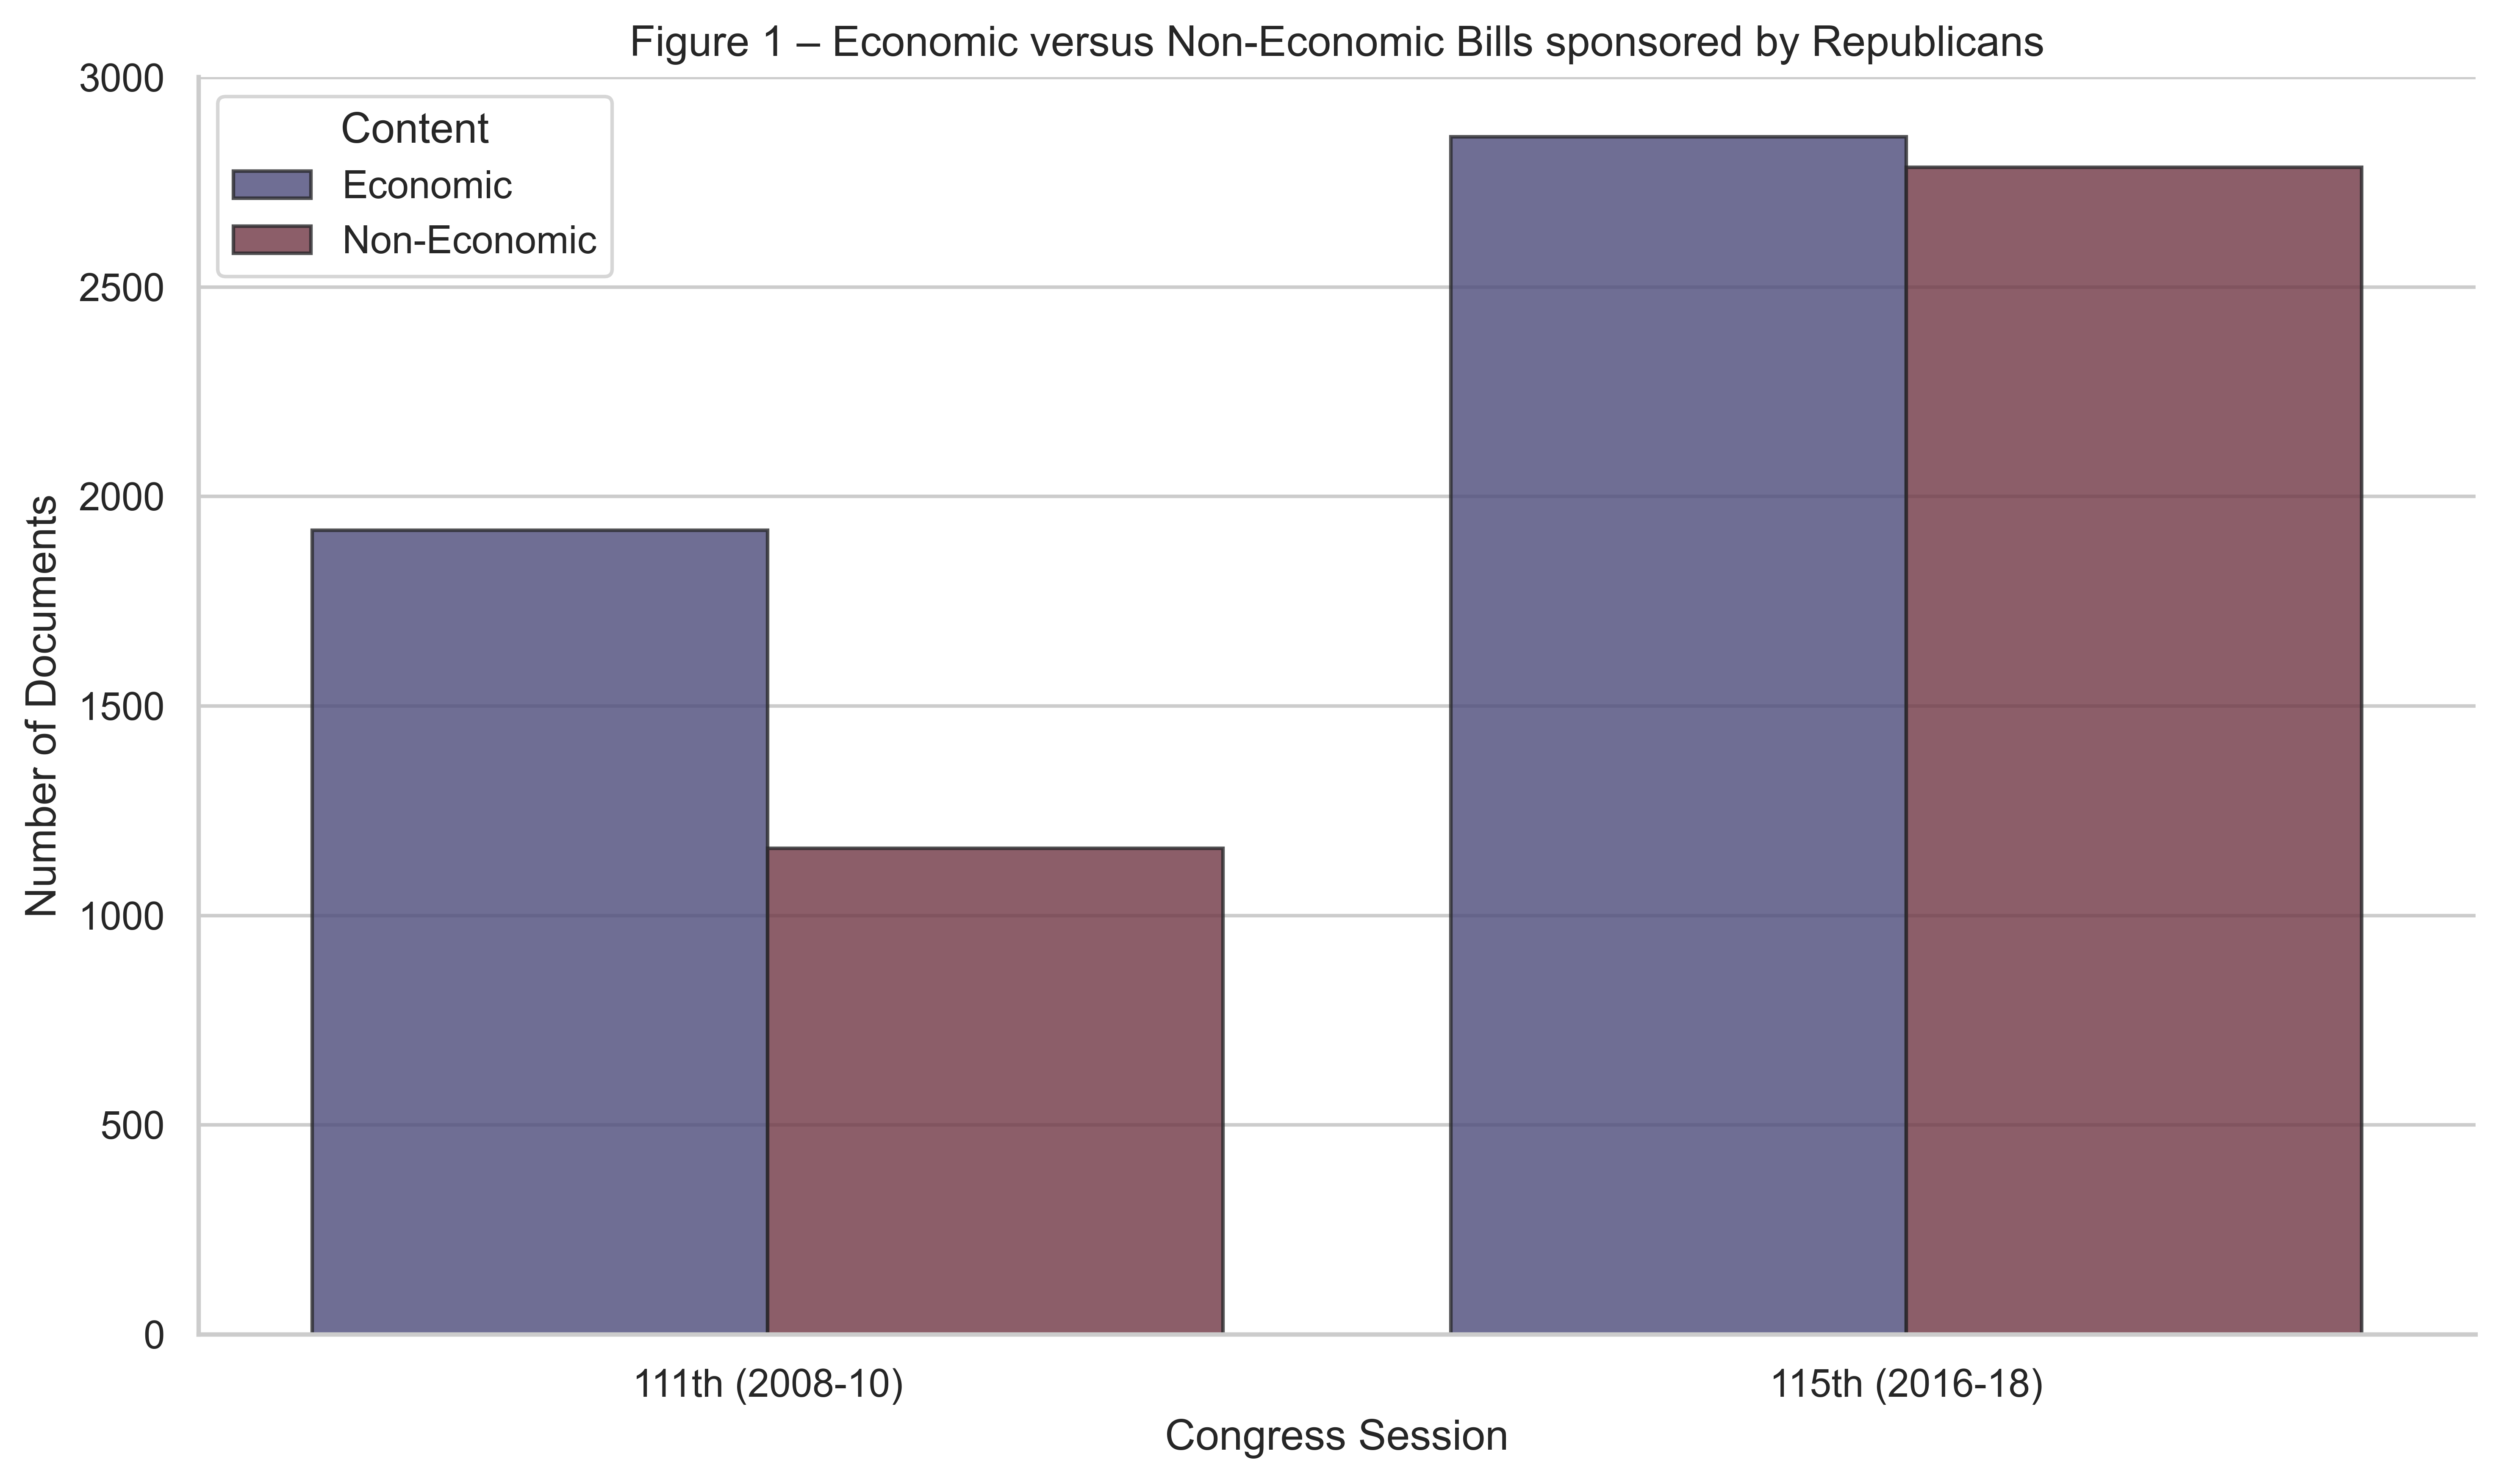

In [10]:
# a. Economic / Non-Economic

# I set the graph's overall style
sns.set(style = "whitegrid")

# I create the figure and axes matplotlib objects
fig, ax = plt.subplots(figsize = (10, 6), dpi = 600)

# I plot the grouped bar chart with seaborn, factoring in only the bills who were introduced by Republicans
sns.countplot(data = d_republicans, x = "congress", hue = "economic", palette = "icefire",
              hue_order = ["Economic", "Non-Economic"], alpha = 0.8, edgecolor = "#28282B", ax = ax)

# I set the legend title and position
legend = ax.legend(title = "Content", loc = "upper left")

# I set the axis labels and title
ax.set_xlabel("Congress Session")
ax.set_xticklabels(["111th (2008-10)", "115th (2016-18)"])
ax.set_ylabel("Number of Documents")
ax.set_title("Figure 1 – Economic versus Non-Economic Bills sponsored by Republicans")

# I remove the top and right spines
sns.despine()

# I automatically adjust the plot's layout for nicer visualisation
plt.tight_layout()

# I save the plot in high definition
plt.savefig("wn_figure1.png", dpi = 600)

# I show the plot
plt.show()

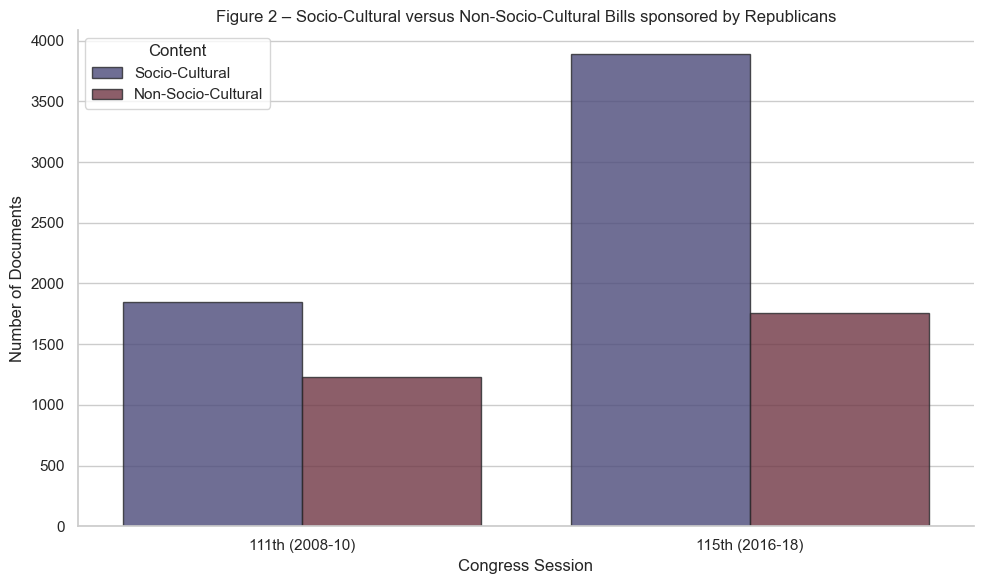

In [11]:
# b. Socio-Cultural / Non-Socio-Cultural

# I set the graph's overall style
sns.set(style = "whitegrid")

# I create the figure and axes matplotlib objects
fig, ax = plt.subplots(figsize = (10, 6))

# I plot the grouped bar chart with seaborn, factoring in only the bills who were introduced by Republicans
sns.countplot(data = d_republicans, x = "congress", hue = "socio_cultural", palette = "icefire",
              hue_order = ["Socio-Cultural", "Non-Socio-Cultural"], alpha = 0.8, edgecolor = "#28282B", ax = ax)

# I set the legend title and position
legend = ax.legend(title = "Content", loc = "upper left")

# I set the axis labels and title
ax.set_xlabel("Congress Session")
ax.set_xticklabels(["111th (2008-10)", "115th (2016-18)"])
ax.set_ylabel("Number of Documents")
ax.set_title("Figure 2 – Socio-Cultural versus Non-Socio-Cultural Bills sponsored by Republicans")

# I remove the top and right spines
sns.despine()

# I automatically adjust the plot's layout for nicer visualisation
plt.tight_layout()

# I save the plot in high definition
plt.savefig("wn_figure2.png", dpi = 600)

# I show the plot
plt.show()

In general, the Republicans introduced a remarkably larger number of bills in the 115th Congress. This is in line with my expectations, because in the 111th Congress they did not elect the President, and represented a minority within both the House of Representatives and the Senate, whereas in the 115th Congress they nominated their candidate as President, while achieving majorities in the two parliamentary chambers. The quantitative increase in documents regarding socio-cultural issues is clear. Moreover, it seems that conservative legislative activity during Trump's presidency was not predominantly guided by economic concerns, suggesting that my hypotheses point towards the right direction. However, since the two categories are not mutually exclusive, I must estimate Linear Probability Models to decouple and measure the main effects of interest - i.e., the probabilities of introducing legislative documents focused, respectively, on economic, or sociocultural issues.

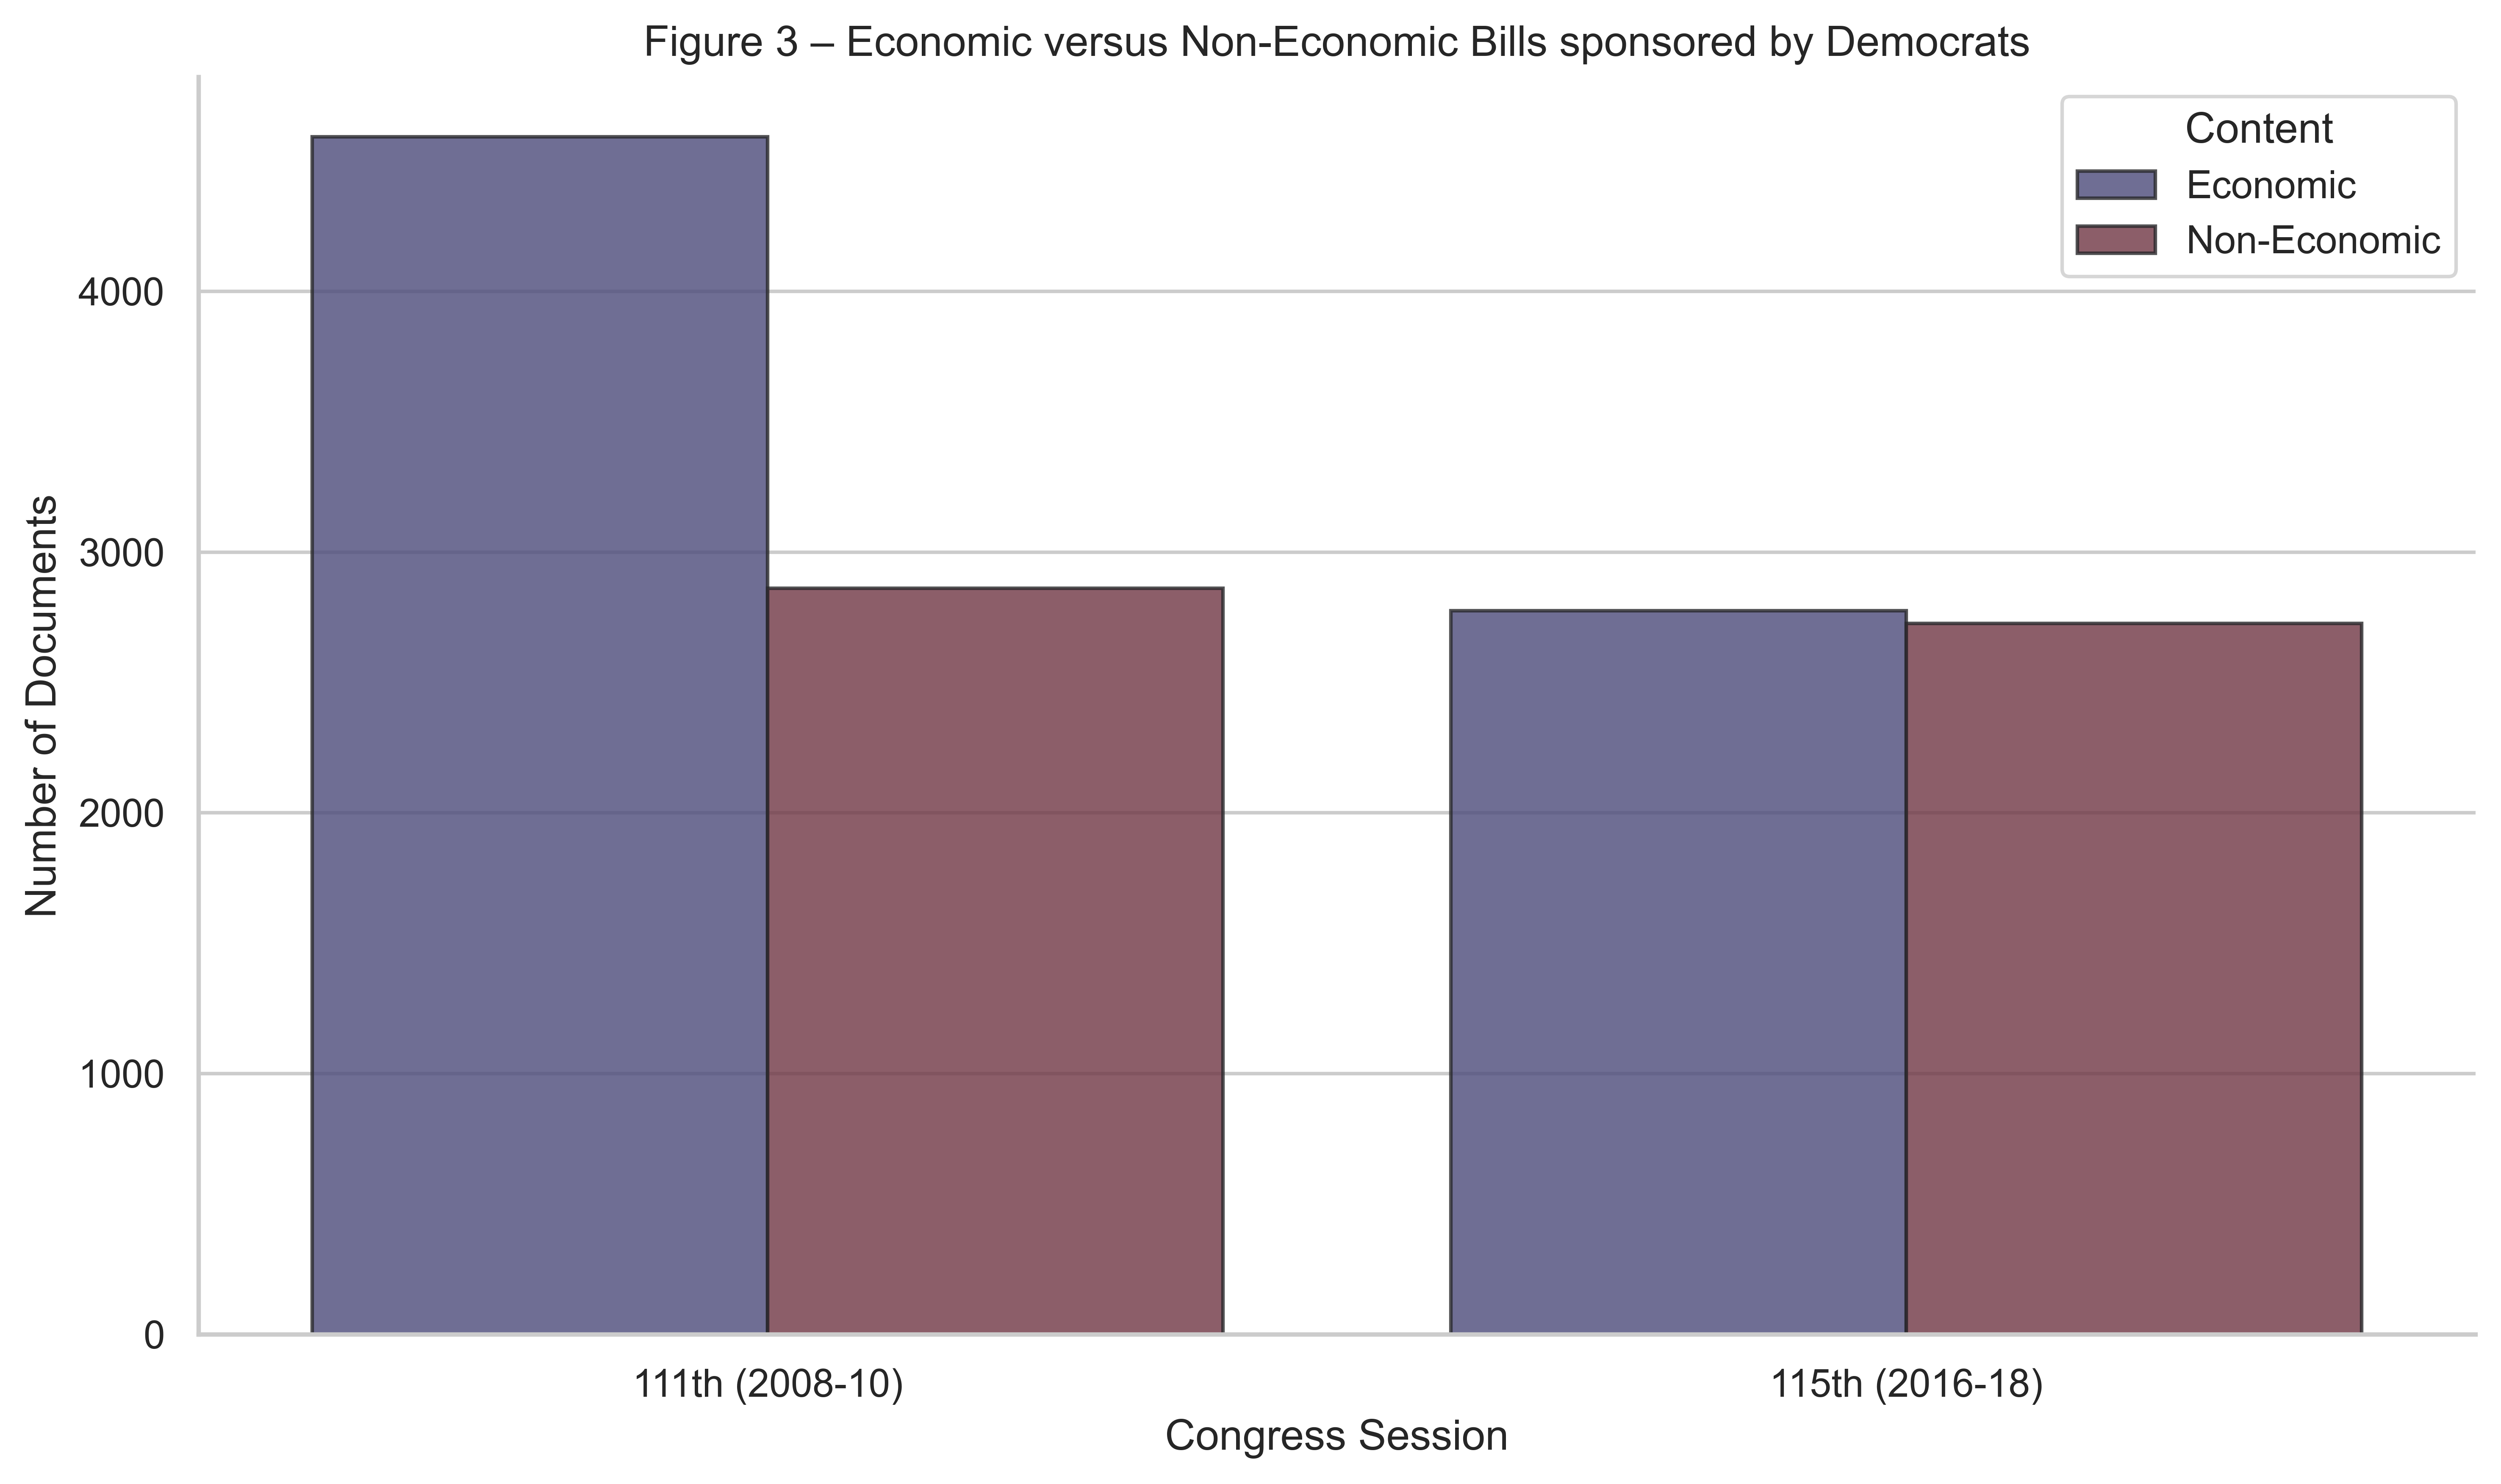

In [12]:
# a. Economic / Non-Economic

# I set the graph's overall style
sns.set(style = "whitegrid")

# I create the figure and axes objects
fig, ax = plt.subplots(figsize = (10, 6), dpi = 600)

# I plot the grouped bar chart with seaborn, factoring in only the bills who were introduced by Democrats
sns.countplot(data = d_democrats, x = "congress", hue = "economic", palette = "icefire",
              hue_order = ["Economic", "Non-Economic"], alpha = 0.8, edgecolor = "#28282B", ax = ax)

# I set the legend title and position
legend = ax.legend(title = "Content", loc = "upper right")

# I set the axis labels and title
ax.set_xlabel("Congress Session")
ax.set_xticklabels(["111th (2008-10)", "115th (2016-18)"])
ax.set_ylabel("Number of Documents")
ax.set_title("Figure 3 – Economic versus Non-Economic Bills sponsored by Democrats")

# I remove the top and right spines
sns.despine()

# I automatically adjust the plot's layout for nicer visualisation
plt.tight_layout()

# I save the plot in high definition
plt.savefig("wn_figure3.png", dpi = 600)

# I show the plot
plt.show()

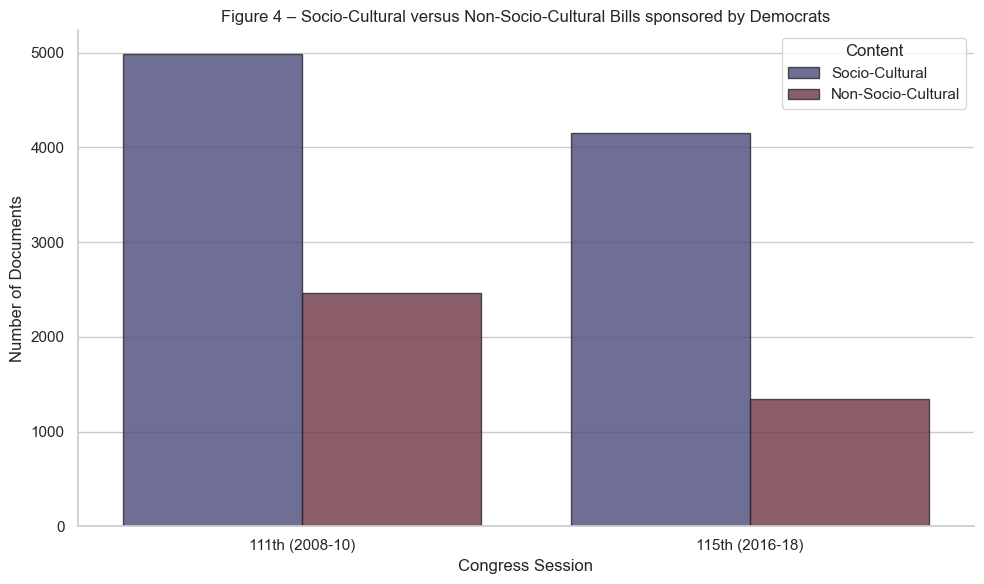

In [13]:
# b. Socio-Cultural / Non-Socio-Cultural

# I set the graph's overall style
sns.set(style = "whitegrid")

# Create the figure and axes objects
fig, ax = plt.subplots(figsize = (10, 6))

# I plot the grouped bar chart with seaborn, factoring in only the bills who were introduced by Democrats
sns.countplot(data = d_democrats, x = "congress", hue = "socio_cultural", palette = "icefire",
              hue_order = ["Socio-Cultural", "Non-Socio-Cultural"], alpha = 0.8, edgecolor = "#28282B", ax = ax)

# I set the legend title and position
legend = ax.legend(title = "Content", loc = "upper right")

# I set the axis labels and title
ax.set_xlabel("Congress Session")
ax.set_xticklabels(["111th (2008-10)", "115th (2016-18)"])
ax.set_ylabel("Number of Documents")
ax.set_title("Figure 4 – Socio-Cultural versus Non-Socio-Cultural Bills sponsored by Democrats")

# I remove the top and right spines
sns.despine()

# I automatically adjust the plot's layout for nicer visualisation
plt.tight_layout()

# I save the plot in high definition
plt.savefig("wn_figure4.png", dpi = 600)

# I show the plot
plt.show()

In general, the Democrats introduced a moderately lower number of bills in the 115th Congress. This is in line with my expectations, because in the 111th Congress they elected the President, and achieved majority status within both the House of Representatives and the Senate, whereas in the 115th Congress they did not nominate their candidate as President, while representing minorities in the two parliamentary chambers. This change impacted parliamentary activities on socio-cultural concerns quite uniformly. Contrariwise, the dynamics in the material dimension are clearer, as economic legislation became less prominent over time. I suspect these developments were driven by the absence of budgetary and financial policies regarding public healthcare during Trump's administration, as opposed to Obama's first term, but I leave a deeper exploration of this suggestion to future research. To wrap up my study, I turn to devising a simple statistical analysis to formally evaluate my research questions and hypotheses.

## 4. Statistical Analysis

I estimate two fixed-effects OLS regressions to predict the likelihood of a bill sponsored by a Republican being Economic, or Socio-Cultural in nature, over time - i.e., by a dummy variable set to 1 if the Bill was introduced in the 115th Congress, or 0 otherwise. I control the main independent variable's coefficient for state-specific characteristics, accounting for the diversity between legislators that are elected by different constituencies. I employ Florida as the reference category by dropping its corresponding dummy because it constitutes an historical swing state that became gradually more conservative due to polarisation on economic and socio-cultural issues.

In [14]:
# a. Economic / Non-Economic

# I create the "states" DataFrame by extracting state-specific dummies from the "sponsor_state" column
# with the pandas "get_dummies" method. I drop the dummy for Florida, which constitutes the reference category.

states = pd.get_dummies(d_republicans["sponsor_state"], prefix = None).drop("FL", axis = 1)

# I concatenate the state-specific dummies with data for the main independent variable by transforming the Congress term's
# numeric identifier into 0 and 1 values. 1 is assigned to bills introduced during the 115th Congress.

independent = pd.concat([d_republicans["congress"].replace({111: 0, 115: 1}), states], axis = 1)

# After defining the independent variables, I generate the dependent variable set by transforming the Economic / Non-
# Economic categories into 0 and 1 values. 1 is assigned to the positive labels.
dependent = d_republicans["economic"].replace({"Non-Economic": 0, "Economic": 1})

# I manually add the constant necessary for the intercept's estimation. I define it as the first column in the
# "independent" set, so that the intercept's coefficient is shown first when printing the model summary.

independent = sm.add_constant(independent, prepend = True)

# I set the OLS model's structure by specifying the "dependent" and "independent" variables.

model_eco_rep = sm.OLS(dependent, independent)

# I fit the OLS model and save the estimates into the "results_eco_rep" object.

results_eco_rep = model_eco_rep.fit()

Since I have no reason to believe that the homoscedasticity assumption is not violated, I carry out an empirical test for heteroscedasticity of residuals, devised by Halbert White in 1980. I ground my methodological choice on the user `Ben Sila`'s explanation in [this](https://stats.stackexchange.com/questions/47490/breusch-pagan-test-for-heteroscedasticity-contradicts-whites-test) StackExchange thread. More specifically, I employ White's test rather than the standard Breusch-Pagan test because the former is able to detect more general forms of heteroskedasticity. The code executed in the following cells is inspired by [this tutorial](https://www.statology.org/white-test-in-python/) written by the user `Zach`.

In [15]:
# I obtain the residuals for the Economic / Non-Economic OLS regression with the ".resid" statsmodels method.

residuals_eco_rep = results_eco_rep.resid

# I feed the residuals and the exogenous variables in the Economic / Non-Economic OLS regression to the "het_white"
# function, which automatically computes White's test statistic and its correspondent p-value.

white_test_eco_rep = het_white(residuals_eco_rep, model_eco_rep.exog)

# I extract and print White's test statistic and its correspondent p-value.

print(f"The White test statistic is equal to {'{:.3f}'.format(white_test_eco_rep[0])}",
      f"with a p-value of {'{:.3f}'.format(white_test_eco_rep[1])}.")

The White test statistic is equal to 375.965 with a p-value of 0.000.


White's test on the Economic / Non-Economic OLS regression exhibits a p-value that is extremely close to zero, leading me to confidently reject the null hypothesis of homoscedasticity of residuals. This means I must instruct `statsmodels` to compute heteroscedasticity-robust standard errors with the `get_robustcov_results` method's `cov_type` argument. In accordance with [Scott Long and Ervin's (2000)](https://www.tandfonline.com/doi/abs/10.1080/00031305.2000.10474549) methodological recommendations, I employ the `HC3` covariance matrix.

In [16]:
# I estimate the OLS model with heteroscedasticity-consistent standard errors.
robust_eco_rep = results_eco_rep.get_robustcov_results(cov_type = "HC3")

# I print the robust OLS model's summary.
print(robust_eco_rep.summary())

                            OLS Regression Results                            
Dep. Variable:               economic   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     6.922
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           5.49e-44
Time:                        20:50:43   Log-Likelihood:                -6136.4
No. Observations:                8723   AIC:                         1.237e+04
Df Residuals:                    8673   BIC:                         1.273e+04
Df Model:                          49                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5647      0.023     24.377      0.0

Bills introduced by Republican sponsors during the 115th Congress were 10.82% less likely to be economic in nature. The effect is negative and significant at the 95% level even when controlling for state-specific diversities between legislators elected by different constituencies. In sum, there is empirical evidence that corroborates my hypothesis that the GOP did not experience a notable increase in its legislative activities focused on economic issues within the US Congress between Obama's first and Trump's first mandates in the Presidential office.

In [17]:
# b. Socio-Cultural / Non-Socio-Cultural

# I must not re-define the independent variables, since the fixed part is constant across models.

# I generate the dependent variable set by transforming the Socio-Cultural / Non-Socio-Cultural categories into 0 and 1
# values. 1 is assigned to the positive labels.

dependent = d_republicans["socio_cultural"].replace({"Non-Socio-Cultural": 0, "Socio-Cultural": 1})

# I set the OLS model's structure by specifying the "dependent" and "independent" variables.

model_sc_rep = sm.OLS(dependent, independent)

# I fit the OLS model and save the estimates into the "results_sc_rep" object.

results_sc_rep = model_sc_rep.fit()

Since I have no reason to believe that the homoscedasticity assumption is not violated, I carry out an empirical test for heteroscedasticity of residuals, devised by Halbert White in 1980. I ground my methodological choice on the user `Ben Sila`'s explanation in [this](https://stats.stackexchange.com/questions/47490/breusch-pagan-test-for-heteroscedasticity-contradicts-whites-test) StackExchange thread. More specifically, I employ White's test rather than the standard Breusch-Pagan test because the former is able to detect more general forms of heteroskedasticity. The code executed in the following cells is inspired by [this tutorial](https://www.statology.org/white-test-in-python/) written by the user `Zach`.

In [18]:
# I obtain the residuals for the Socio-Cultural / Non-Socio-Cultural OLS regression with the ".resid" statsmodels method.

residuals_sc_rep = results_sc_rep.resid

# I feed the residuals and the exogenous variables in the Socio-Cultural / Non-Socio-Cultural OLS regression to the
# "het_white" function, which automatically computes White's test statistic and its correspondent p-value.

white_test_sc_rep = het_white(residuals_sc_rep, model_sc_rep.exog)

# I extract and print White's test statistic and its correspondent p-value.

print(f"The White test statistic is equal to {'{:.3f}'.format(white_test_sc_rep[0])}",
      f"with a p-value of {'{:.3f}'.format(white_test_sc_rep[1])}.")

The White test statistic is equal to 324.470 with a p-value of 0.000.


White's test on the Socio-Cultural / Non-Socio-Cultural OLS regression exhibits a p-value that is extremely close to zero, leading me to confidently reject the null hypothesis of homoscedasticity of residuals. This means I must instruct `statsmodels` to compute heteroscedasticity-robust standard errors with the `get_robustcov_results` method's `cov_type` argument. In accordance with [Scott Long and Ervin's (2000)](https://www.tandfonline.com/doi/abs/10.1080/00031305.2000.10474549) methodological recommendations, I employ the `HC3` covariance matrix.

In [19]:
# I estimate the OLS model with heteroscedasticity-consistent standard errors.
robust_sc_rep = results_sc_rep.get_robustcov_results(cov_type = "HC3")

# I print the robust OLS model's summary.
print(robust_sc_rep.summary())

                            OLS Regression Results                            
Dep. Variable:         socio_cultural   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     97.81
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:50:50   Log-Likelihood:                -5704.6
No. Observations:                8723   AIC:                         1.151e+04
Df Residuals:                    8673   BIC:                         1.186e+04
Df Model:                          49                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7029      0.020     34.813      0.0

Bills introduced by Republican sponsors during the 115th Congress were 8.29% more likely to be socio-cultural in nature. The effect is positive and significant at the 95% level even when controlling for state-specific diversities between legislators elected by different constituencies. In sum, there is empirical evidence that corroborates my hypothesis that the GOP witnessed a surge in its legislative activities pertaining to socio-cultural matters within the US Congress between Obama's first and Trump's first mandates in the Presidential office.

## 5. Wrapping Up

The data analysis ends here. I will make sure to appropriately report the results and include my interpretations in the paper. I wrap up this notebook with two key observations concerning my choice of methods. First, logistic regression estimates are affected by omitted covariates, even when these predictors are unrelated to the independent variables in the model. Importantly, I would not be able to straightforwardly interpret log-odds ratios or odds ratios as effect measures, because they also reflect the degree of unobserved heterogeneity. Furthermore, comparisons between log-odds ratios or odds ratios across the two models would be meaningless. I consequently decide to employ OLS estimators to generate Linear Probability Models (LPMs), as recommended by [Mood (2010)](https://academic.oup.com/esr/article/26/1/67/540767). Second, a more extensive information retrieval procedure could open up possibilities for estimating mixed-effects models, which would take into account the data's hierarchical structure, as bills are nested in Congress terms. However, the number of Level-1 units - i.e., documents - would greatly exceed the amount of Level-2 clusters - i.e., Congress terms - pointing towards the need of using restricted ML estimators for variance parameters, and a t-distribution with a Satterthwaite or Kenway-Roger denominator-degrees-of-freedom adjustment technique for statistical inference, as suggested by [Elff et al. (2021)](https://www.cambridge.org/core/journals/british-journal-of-political-science/article/multilevel-analysis-with-few-clusters-improving-likelihoodbased-methods-to-provide-unbiased-estimates-and-accurate-inference/B2328D08B0BB80C2A113DDCC52C4DD1D).

